In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define the encoder network


class cVAEEncoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super(cVAEEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim )  #
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class UcVAEEncoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super(UcVAEEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, labels):
        # x = torch.cat([x, labels], dim=1)
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# Define the decoder network


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.net=nn.Sequential(
            nn.Linear(latent_dim + label_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        z = torch.cat([z, labels], dim=1)
        x_recon = self.net(z)
        return x_recon

# Define the cVAE model


class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim, mode='cVAE'):
        super(CVAE, self).__init__()
        if mode == 'cVAE':
            self.encoder = cVAEEncoder(
                input_dim, label_dim, hidden_dim, latent_dim)
        elif mode == 'UcVAE':
            self.encoder = UcVAEEncoder(
                input_dim, label_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, label_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, labels)
        return x_recon, mu, logvar

# Loss function


def loss_function(x_recon, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Training the cVAE


def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (x, labels) in enumerate(dataloader):
            x = x.view(x.size(0), -1).to(device)
            labels = torch.nn.functional.one_hot(
                labels, num_classes=10).float().to(device)  # no useful for UcVAE

            optimizer.zero_grad()
            x_recon, mu, logvar = model(x, labels)
            loss = loss_function(x_recon, x, mu, logvar)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader.dataset):.4f}")


# Example using MNIST dataset
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)


In [4]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)

input_dim = 28 * 28  # Size of MNIST images (28x28)
label_dim = 10       # Number of classes in MNIST (0-9)
hidden_dim = 400     # Hidden layer size
latent_dim = 20      # Latent space dimension

# Instantiate the model and move it to GPU
cvae = CVAE(input_dim, label_dim, hidden_dim,
            latent_dim, mode="cVAE").to(device)
ucvae = CVAE(input_dim, label_dim, hidden_dim,
             latent_dim, mode="UcVAE").to(device)

In [5]:
# Define the optimizer
optimizer_cvae = optim.Adam(cvae.parameters(), lr=5e-4)
optimizer_ucvae = optim.Adam(ucvae.parameters(), lr=5e-4)
# Train the model
train_model(cvae, train_loader, optimizer_cvae, num_epochs=40)
train_model(ucvae, train_loader, optimizer_ucvae, num_epochs=40)

Epoch [1/40], Loss: 190.0608
Epoch [2/40], Loss: 146.4617
Epoch [3/40], Loss: 137.9855
Epoch [4/40], Loss: 135.0139
Epoch [5/40], Loss: 133.4626
Epoch [6/40], Loss: 131.9455
Epoch [7/40], Loss: 129.4276
Epoch [8/40], Loss: 126.3846
Epoch [9/40], Loss: 124.4705
Epoch [10/40], Loss: 123.5856
Epoch [11/40], Loss: 122.9555
Epoch [12/40], Loss: 122.1907
Epoch [13/40], Loss: 121.3515
Epoch [14/40], Loss: 121.1233
Epoch [15/40], Loss: 120.3148
Epoch [16/40], Loss: 119.4715
Epoch [17/40], Loss: 118.2891
Epoch [18/40], Loss: 116.7977
Epoch [19/40], Loss: 115.4423
Epoch [20/40], Loss: 114.5036
Epoch [21/40], Loss: 113.7585
Epoch [22/40], Loss: 113.2725
Epoch [23/40], Loss: 112.9606
Epoch [24/40], Loss: 112.5607
Epoch [25/40], Loss: 112.2969
Epoch [26/40], Loss: 111.8814
Epoch [27/40], Loss: 111.5092
Epoch [28/40], Loss: 111.4641
Epoch [29/40], Loss: 111.2166
Epoch [30/40], Loss: 110.8343
Epoch [31/40], Loss: 110.6679
Epoch [32/40], Loss: 110.4005
Epoch [33/40], Loss: 110.3753
Epoch [34/40], Loss

In [11]:

# Function to generate samples
def generate_samples(model, label, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Sample random latent vectors from a standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)

        # Convert label to one-hot and repeat for each sample
        labels = torch.nn.functional.one_hot(torch.tensor(
            [label] * num_samples), num_classes=10).float().to(device)

        # Use the decoder to generate samples
        samples = model.decoder(z, labels)

        # Reshape the samples back to the image shape (28x28 for MNIST)
        samples = samples.view(num_samples, 28, 28).cpu().numpy()

        return samples

# Visualize generated samples


def plot_samples(samples,title):
    fig, axes = plt.subplots(samples.shape[0], samples.shape[1], figsize=(
        samples.shape[0], samples.shape[1]))
    for i, sample_row in enumerate(samples):
        for j, sample in enumerate(sample_row):
            axes[i, j].imshow(sample)  # , cmap='gray'
            axes[i, j].axis('off')
    fig.suptitle(title, fontsize=32)
    plt.show()



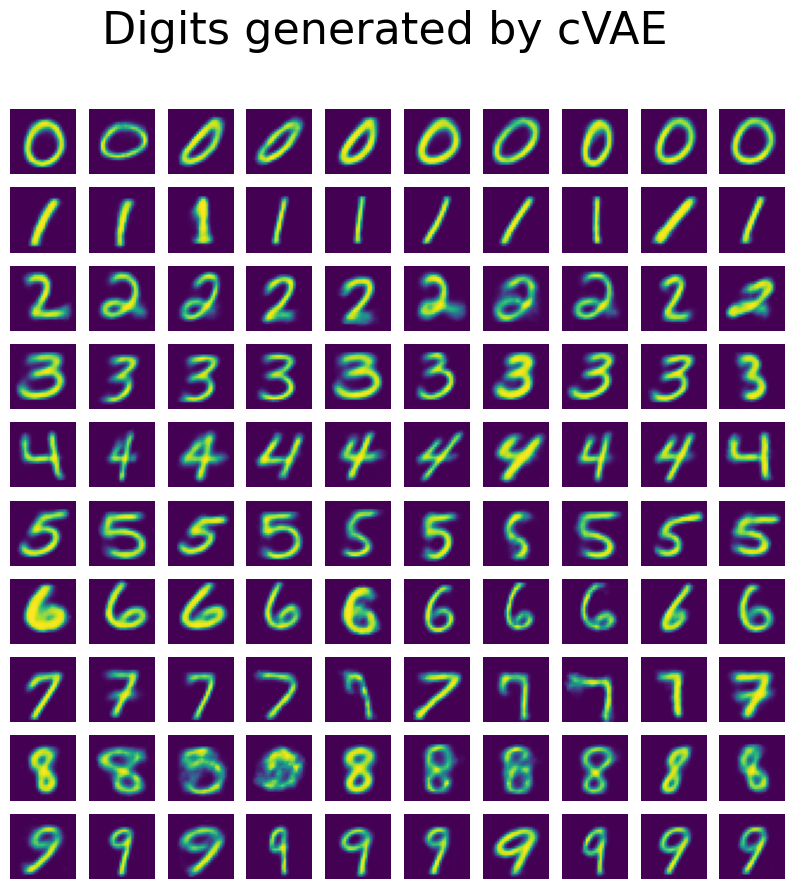

In [18]:
samples_cvae = []
for label in range(10):
    samples = generate_samples(cvae, label, num_samples=10)
    samples_cvae.append(samples)

# Plot the generated samples
plot_samples(np.array(samples_cvae),"Digits generated by cVAE")


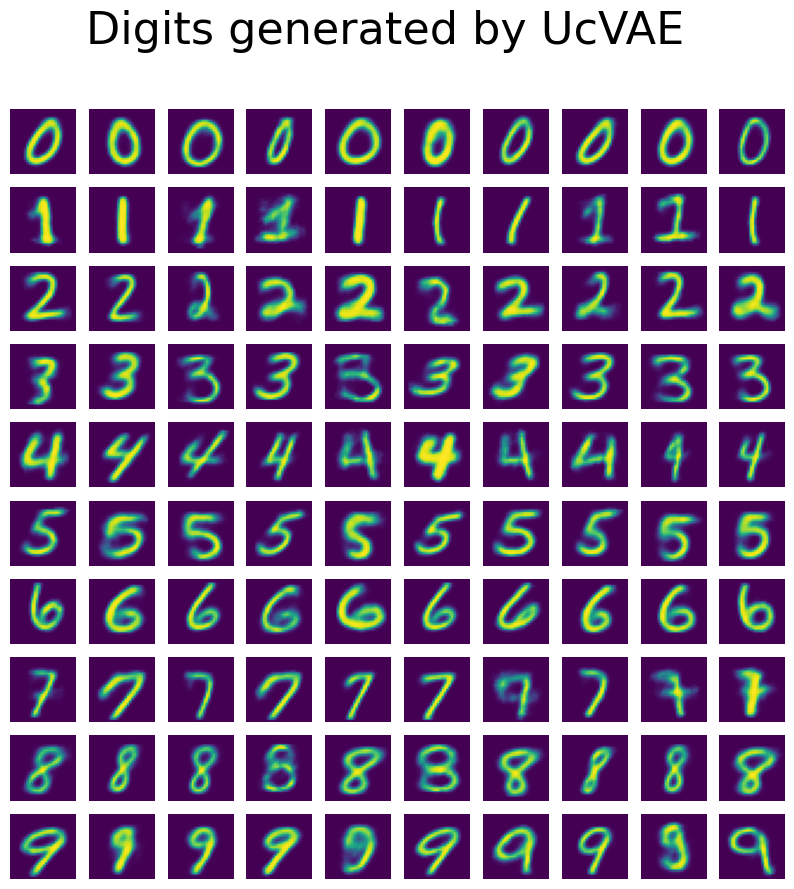

In [16]:
samples_ucvae = []
for label in range(10):
    samples = generate_samples(ucvae, label, num_samples=10)
    samples_ucvae.append(samples)

# Plot the generated samples
plot_samples(np.array(samples_ucvae),"Digits generated by UcVAE")